### Importing required packages 

In [1]:
import pandas as pd
import numpy as np
import gzip
import nltk
import re
import os
import matplotlib.pyplot as plt
import json
import nltk
import wikipedia
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings("ignore")


## Functions for specific operation

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def Remove_URLs(x):
    '''
    Function to remove URLS related information from Raw Text
    '''
    x = x.split(' ')
    x = [i for i in x if not len(re.findall(r'[\w\.-]+@[\w\.-]+',i))]
    x = ' '.join(x)
    return x

def tokenizing(x):
    '''
    Function to tokenize the data
    '''
    return nltk.tokenize.word_tokenize(x)

def stopwords(x):
    '''
    Function to remove stop words from the Raw text data
    '''
    stop_words=nltk.corpus.stopwords.words('english')
    x=[i for i in x if i not in stop_words]
    return x

def Lemmatization(x):
    '''
    Function to replace the similar words with the root of specific words
    '''
    lemmatizer=nltk.stem.WordNetLemmatizer()
    x = [ lemmatizer.lemmatize(i) for i in x]
    return x

def Stemming(x):
    '''
    Function to perform operation of stemming on the Text data
    '''
    ps = nltk.stem.PorterStemmer() 
    x = [ps.stem(i) for i in x]
    return x

def Remove_numbers(x):
    '''
    Function to Remove numbers information from the data
    '''
    x = [re.sub('[^A-Z,a-z]+','',i) for i in x]
    x = ' '.join(x).lower()
    return x

def preprocess(x):
    '''
    Function to apply basic preprocessing techniques on the given data
    '''
    x = Remove_URLs(x)
    x = tokenizing(x)
    x = stopwords(x)
    x = Lemmatization(x)
    #x = Stemming(x)
    x = Remove_numbers(x)
    return x

def SplitText(text):
    '''
    Application Specific
    ---------------------
    Application wise preprocessing for the Questions extracted data from National consumer help line site.
    
    '''
    text =list(map(lambda x: x[2:],re.sub(r'[0-2]','',text).split('\n')))
    return [i.replace('/','') for i in text if len(i)>1]

def ExtractPOS(text, parts=['verb','adverb','noun','adj','preps']):
    '''
    Function to select only specific asked Parst from speech with the use of nltk Parts-of-Speech tagging.
    specified list tags
    '''
    POS = pd.Series()
    POS['verb'] = ['VB','VBD','VBG','VBN','VBP','VBZ']
    POS['adverb'] = ['WDT','W','WP','WRB']
    POS['noun'] = ['NN','NNS','NNP', 'NNPS']
    POS['adj'] = ['JJ','JJR','JJS']
    POS['preps'] = ['PRP','IN']
    word_tags = nltk.pos_tag(nltk.tokenize.word_tokenize(text.lower()))
    return [tag[0] for tag in word_tags if tag[1] in np.hstack(POS[parts].tolist())]

def search_in_wiki(Sector):
    '''
    Function to search for specific word in the Wikipedia. Function will only returns the summary of wikipedia page 
    information
    '''
    try:
        summary = wikipedia.summary(Sector)
    except wikipedia.DisambiguationError as e:
        Sector = e.options[np.random.randint(len(e.options))]
        summary = wikipedia.summary(Sector)
    return summary


def RemoveTextOutliers(ProductSummary):
    '''
    Function to remove the outliers from text
    
    Here Gensim vector generation technique have used in generating the features for each word.
    Once the 104 dimensional vector have generated for each word, Sklearn 104 dimensional K-Means cluster will be build 
    for all the given words.
    Based on the Distribution of distances between Cluster centroid, Outlier words will be removed from the Text
    
    '''
    ProductNounVector = pd.Series()
    Nouns = ExtractPOS(ProductSummary,parts=['noun'])
    ProductNouns = pd.Series(nltk.FreqDist(Nouns))
    for noun in ProductNouns.keys():
        try:
            ProductNounVector[noun] = word_vectors[noun]
        except:
            pass

    kmeans = KMeans(n_clusters=1, random_state=0).fit(np.vstack(ProductNounVector.values))
    ClusterCenter = kmeans.cluster_centers_

    ClusterDistances = np.vstack(ProductNounVector) - ClusterCenter
    ClusterDistances = pd.Series(np.apply_along_axis(np.linalg.norm, 1, ClusterDistances), index=ProductNounVector.index)

    #ProductNouns = ProductNouns[ClusterDistances[ClusterDistances<5].index]
    ProductNouns = ProductNouns[ClusterDistances[ClusterDistances<ClusterDistances.quantile(.7)].index]

    return ProductNouns


def Automatic_Sector(ProductSummary):
    '''
    Application Specific
    ---------------------
    Application Specific Function in selecting the sector associated with the given word
    '''
    ProductNouns = RemoveTextOutliers(ProductSummary)
    ProductSectorRating = {}
    for Sector in ComplaintSectors.keys():
        ProductSectorRating[Sector] = 0
        for word, weight in ProductNouns.items():
            try:
                ProductSectorRating[Sector] += word_vectors.similarity(Sector.lower().split()[0],word) *weight
            except:
                pass

    ProductSectorRating = pd.Series(ProductSectorRating)
    ProductSector = ProductSectorRating.idxmax()
    return ProductSector

### Intended Preprocessing

    ## Preparing Questionnaire

    ### 1- GPT-2 to summarize the terms information
    ### 2- extracting the verbs and nouns information
    ### 3- Prepare a Question based on the 

## Mandatory Conditions Extraction

# Questionnaire Preparation

In [3]:
import gensim.downloader as api
from sklearn.cluster import KMeans

word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

In [4]:
# ComplaintSectorRaw = {'Airlines' : Conditions_Airlines,
#                    'Automobiles vehicles' : Conditions_Automobiles,
#                    'Banking sector' : Conditions_Banking,
#                    'Domestic Applications' : Conditions_DomesticApp,
#                    'Electricity' : Conditions_Electricity,
#                    'Food Safety' : Conditions_FoodSafety,
#                    'Insurance' :Conditions_Insurance,
#                    'Legal Metrology':Conditions_LegalMetrology,
#                    'Medical Negligence':Conditions_MedicalNegligence,
#                    'NonBank Finance':Conditions_NonBankFC,
#                    'Petroleum':Conditions_Petroleum,
#                    'Postal':Conditions_Postal,
#                    'Public Distributions':Conditions_PublicDistS,
#                    'Real Estate':Conditions_RealEstate}
# ComplaintSectors = dict([(SectorName,SplitText(Sector)) for SectorName, Sector in ComplaintSectorRaw.items()])


# with open('ComplaintsLog.json','w') as file:
#     json.dump(ComplaintSectors,file)

In [5]:
with open('ComplaintsLog.json','r') as file:
    ComplaintSectors = json.load(file)

In [14]:
# Product_Summaries = [wikipedia.summary(Sector) for Sector in ComplaintSectors.keys()]
string = 'postal'
Product_Summaries = {}
for Sector in ComplaintSectors.keys():
    try:
        summary = search_in_wiki(Sector)
    except:
        print(Sector,' Could not find from WIKI')
    Product_Summaries[Sector] = summary

Postal  Could not find from WIKI


In [25]:
ProductName = 'aashirvaad ghee'
#ProductName = 'basmati rice'
# ProductRatings = pd.Series(dict([(i,np.linalg.norm(word_vectors[i.split()[0].lower()]-word_vectors[ProductName])) for i in Product_Summaries.keys()]))
# FreqComplaints = ComplaintSectors[ProductRatings.idxmin()]

In [26]:
for 
    ProductSummary = search_in_wiki(ProductName)
    ProductSummary = preprocess(ProductSummary)

PageError: Page id "aashirwaad ghar" does not match any pages. Try another id!

In [8]:
ProductSummary

'mahindra tractors international farm equipment manufacturer mahindra  mahindra  in  , mahindra became world s highestselling tractor brand volume  mahindra s largest consumer base india , china , north america , growing market australia  the company largest manufacturer india capacity build , tractor yearm  m produced first tractor  , mahindra b  mahindra tractors sold , unit annually making one largest tractor producer world  to expand growing tractor market china , mahindra acquired majority stake jiangling  to raise awareness mahindra us , mahindra usa announced new sponsorship nascar nationwide series r motorsports , participating   mahindra tractors chevrolet  the car driven robert richardson jr mahindra usa , inc announced race primary race associate sponsorship  nascar nationwide series  with sponsorship , mahindra first indian company sponsor car nascar  in  , mahindra sponsor mcdonald motorsports team ran   car nascar nationwide series '

In [23]:
Sector = 'Food Safety'

In [17]:
FreqComplaints = ComplaintSectors['Food Safety']

In [19]:

ComplaintsSimilairity = pd.Series(dict([(complaint,word_vectors.wmdistance(ProductSummary.lower().split(), complaint.lower().split())) for complaint in FreqComplaints]))

In [20]:
ComplaintsSimilairity.sort_values()

Sale of packaged food articles after expiry of best before date.    6.011220
Insect, dust, fungus in ready to serve drinks                       6.094735
Adulteration of spice powders                                       6.615387
Adulteration of ghee, milk, pulses                                  6.663410
dtype: float64

In [30]:
for Sector,summary in Product_Summaries.items():
    parts = ['verb','adj']
    ExtractPOS(summary,parts)
    print(Sector, '   ', word_vectors.wmdistance(ExtractPOS(Product_Wiki_info,parts), ExtractPOS(summary,parts)))
    #print(Sector, '   ', word_vectors.wmdistance(Product_Wiki_info.lower().split(), summary.lower().split()))
    

Airlines     5.354147165909887
Automobiles vehicles     5.34711407441677
Banking sector     5.53897540369214
Domestic Applications     5.14851041210692
Electricity     5.103478266730117
Food Safety     4.8938753106938595
Insurance     4.9831518923374425
Legal Metrology     5.261231801128879
Medical Negligence     5.619227851895438
NonBank Finance     5.340128814766407
Petroleum     5.1664723781576605
Going postal (disambiguation)     5.1664723781576605
Public Distributions     5.155120028153723
Real Estate     5.024941283907499


# Image Processing
## Extracting the Helpful Reviws

In [2]:
# Preprocessing
from selenium import webdriver
from IPython.display import Image
#import cv2
import pickle
from PIL import Image
import os
import time
import numpy as np
import urllib.request
#from xvfbwrapper import Xvfb
import urllib
from IPython import display
import pytesseract


#  Modelling
import numpy as np
np.random.seed(531)
# from keras.layers import Input,Dense,Dropout,Conv1D,Conv2D,Activation,LSTM,MaxPooling2D
# from keras.models import Model,model_from_json
# import keras
import h5py
from IPython.core.debugger import set_trace
import tensorflow as tf


def as_keras_metric(method):
    import functools
    from tensorflow.keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)
from tensorflow.keras.callbacks import EarlyStopping
import keras
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
loaded_images = []
def Preprocess_Images(person,data_location):
    images = os.listdir(os.path.join(data_location,person))
    
    Preprocess_data = {}
    for i in images:
        Img = Image.open(os.path.join(data_location,person,i))
        Img = Img.resize((139,139),Image.ANTIALIAS)
        if len(np.array(Img).shape) == 3 and np.array(Img).shape[2]==3:
            Preprocess_data[i] = np.array(Img)
            #train_person.append(np.array(Img))
    
    global loaded_images
    loaded_images.append(Preprocess_data)
        
    train_person = np.concatenate([arr[np.newaxis] for arr in list(Preprocess_data.values())])

    print('shape of ',person,' data',train_person.shape)
    return train_person

def Pattern_Preprocessing(folder_location):
    data_location = folder_location
    data_X = np.concatenate([Preprocess_Images(person,data_location) for person in os.listdir(data_location)])
    data_Y = keras.utils.np_utils.to_categorical(np.repeat(np.arange(len(loaded_images)),[len(list(i.values())) for i in loaded_images])[:,None])
    return data_X,data_Y

P_data_X, P_data_Y = Pattern_Preprocessing(r'C:\Users\viswanadhapa\Documents\Naga\Course\WebPage\Data\Images')

shape of  Cocacola  data (203, 139, 139, 3)
shape of  Colgate  data (76, 139, 139, 3)
shape of  Dettol  data (130, 139, 139, 3)
shape of  Kellogs  data (102, 139, 139, 3)
shape of  LirilSoap  data (179, 139, 139, 3)
shape of  Medimix  data (250, 139, 139, 3)
shape of  Pedigree  data (130, 139, 139, 3)
shape of  Pepsodent  data (170, 139, 139, 3)


In [5]:
# Picking the Values Randomly from different clusters to train on data
np.random.seed(531)
Random_numbers = np.random.choice(range(len(P_data_X)),len(P_data_X), replace=False)
train_seq = Random_numbers[:int(0.8*len(P_data_X))]
test_seq = Random_numbers[int(0.8*len(P_data_X)):]
P_Train_X = P_data_X[train_seq]
P_Test_X = P_data_X[test_seq]
P_Train_Y = P_data_Y[train_seq]
P_Test_Y = P_data_Y[test_seq]

In [6]:
from tensorflow.keras.layers import Input,Dense,Dropout,Conv1D,Conv2D,Activation,LSTM,MaxPooling2D,Flatten, Cropping2D, Lambda, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set a couple flags for training - you can ignore these for now
freeze_flag = True  # `True` to freeze layers, `False` for full training
weights_flag = 'imagenet' # 'imagenet' or None
preprocess_flag = True # Should be true for ImageNet pre-trained typically

# Loads in InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

# We can use smaller than the default 299x299x3 input for InceptionV3
# which will speed up training. Keras v2.0.9 supports down to 139x139x3
input_size = 139


# Using Inception with ImageNet pre-trained weights
inception = InceptionV3(weights=weights_flag, include_top=False,
                        input_shape=(input_size,input_size,3))
inception.layers.pop()

if freeze_flag == True:
    ## TODO: Iterate through the layers of the Inception model
    ##       loaded above and set all of them to have trainable = False
    for layer in inception.layers[:-3]:
        layer.trainable = False


def InceptionModel(x_train):
    X_input = Input(x_train.shape)

    X = Cropping2D(cropping=((60,25), (0,0)))(X_input)

    # Re-sizes the input with Kera's Lambda layer & attach to cifar_input
    X = Lambda(lambda image: tf.image.resize_images( 
        image, (input_size, input_size)))(X)

    # Feeds the re-sized input into Inception model
    inp = inception(X)

    model = GlobalAveragePooling2D(data_format=None)(inception.get_output_at(-1))
    model = Dense(240)(model)
    model = Dense(64)(model)
    predictions = Dense(8,activation='softmax')(model)

    # Creates the model, assuming your final layer is named "predictions"
    model = Model(inputs=X_input, outputs=predictions)
    # Compile the model
    model.compile(optimizer='Adam', loss='mse', metrics=[auc_pr])

    # Check the summary of this new model to confirm the architecture
    model.summary()
    return model
# with open('data/ProcessedData.data','rb') as file:
#     x_test, y_test = pickle.load(file)
#     x_valid, y_valid = pickle.load(file)
#     x_train,y_train = pickle.load(file)
#     file.close()

In [7]:
model = InceptionModel(P_Train_X[0])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 139, 139, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 54, 139, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 139, 139, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 240)               491760    
________________

In [8]:
model.fit(P_Train_X, P_Train_Y, epochs=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
992/992 [==============================] - 44s 44ms/sample - loss: 0.1412 - auc_pr: 0.1880
Epoch 2/2
992/992 [==============================] - 43s 43ms/sample - loss: 0.1036 - auc_pr: 0.2955


In [11]:
model.fit(P_Train_X, P_Train_Y, epochs=50)

Epoch 1/50
992/992 [==============================] - 43s 43ms/sample - loss: 0.0885 - auc_pr: 0.3728
Epoch 2/50
992/992 [==============================] - 43s 43ms/sample - loss: 0.0889 - auc_pr: 0.4356
Epoch 3/50
992/992 [==============================] - 48s 48ms/sample - loss: 0.1003 - auc_pr: 0.4608
Epoch 4/50
992/992 [==============================] - 51s 51ms/sample - loss: 0.0765 - auc_pr: 0.4828
Epoch 5/50
992/992 [==============================] - 53s 53ms/sample - loss: 0.0708 - auc_pr: 0.5109
Epoch 6/50
992/992 [==============================] - 51s 52ms/sample - loss: 0.0675 - auc_pr: 0.5296
Epoch 7/50
992/992 [==============================] - 50s 50ms/sample - loss: 0.0678 - auc_pr: 0.5491
Epoch 8/50
992/992 [==============================] - 47s 48ms/sample - loss: 0.0689 - auc_pr: 0.5644
Epoch 9/50
992/992 [==============================] - 47s 47ms/sample - loss: 0.0609 - auc_pr: 0.5786
Epoch 10/50
992/992 [==============================] - 48s 48ms/sample - loss: 0.0

In [9]:
model.save('Inception.h5')

In [12]:
model_json = model.to_json()
with open('Inception.json','w') as file:
    file.write(model_json)
model.save_weights('Inception.h5')

In [35]:
os.listdir(folder)[5]

df = getDF('Data/Reviews/reviews_Home_and_Kitchen_5.json.gz')
folder = 'Data/Reviews'

'reviews_Cell_Phones_and_Accessories_5.json.gz'



 reviews_Amazon_Instant_Video_5.json.gz
Overall Negative Comments associated with reviews are  --  4.627484781554705
Negative values Distributions supported by helpful flag 
 3      40.861467
5       8.498254
10      8.265425
100     5.296857
Name: helpful, dtype: float64


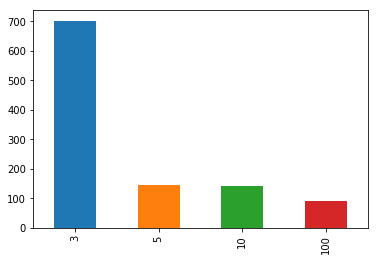



 reviews_Apps_for_Android_5.json.gz
Overall Negative Comments associated with reviews are  --  10.454128300242916
Negative values Distributions supported by helpful flag 
 3      32.837015
5       6.602467
10      7.151296
100     8.607219
Name: helpful, dtype: float64


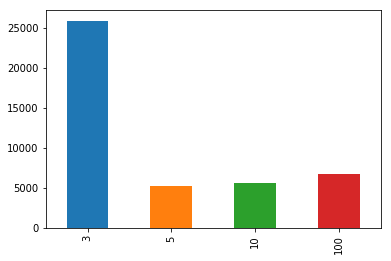



 reviews_Automotive_5.json.gz
Overall Negative Comments associated with reviews are  --  2.6473892443706344
Negative values Distributions supported by helpful flag 
 3      35.793358
5       6.826568
10      5.166052
100     6.457565
Name: helpful, dtype: float64


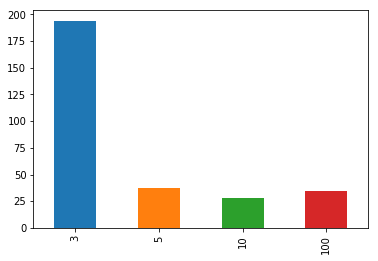



 reviews_Baby_5.json.gz
Overall Negative Comments associated with reviews are  --  4.862804119607941
Negative values Distributions supported by helpful flag 
 3      33.917381
5       5.409899
10      4.668116
100     4.668116
Name: helpful, dtype: float64


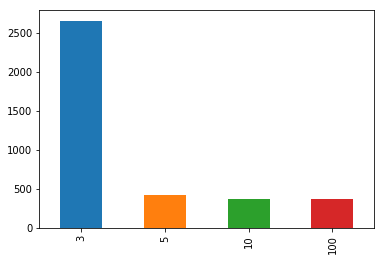



 reviews_Beauty_5.json.gz
Overall Negative Comments associated with reviews are  --  5.302717352973774
Negative values Distributions supported by helpful flag 
 3      37.421623
5       6.517196
10      4.455634
100     4.151625
Name: helpful, dtype: float64


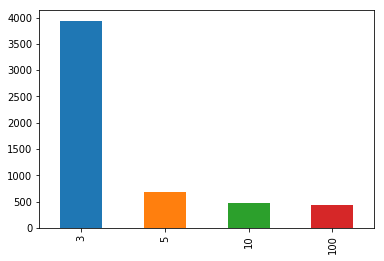



 reviews_Cell_Phones_and_Accessories_5.json.gz
Overall Negative Comments associated with reviews are  --  6.829391222954243
Negative values Distributions supported by helpful flag 
 3      22.531817
5       2.921907
10      2.673394
100     2.598087
Name: helpful, dtype: float64


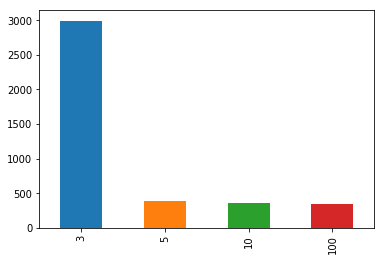



 reviews_Clothing_Shoes_and_Jewelry_5.json.gz
Overall Negative Comments associated with reviews are  --  4.016119019510042
Negative values Distributions supported by helpful flag 
 3      31.361687
5       4.574696
10      3.984989
100     3.100429
Name: helpful, dtype: float64


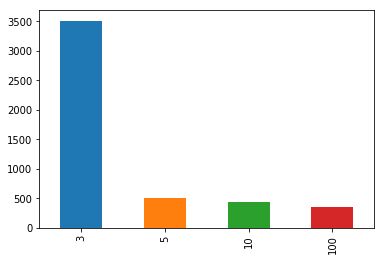



 reviews_Digital_Music_5.json.gz
Overall Negative Comments associated with reviews are  --  4.313355793898556
Negative values Distributions supported by helpful flag 
 3      41.920459
5      17.663920
10     16.302401
100     9.172340
Name: helpful, dtype: float64


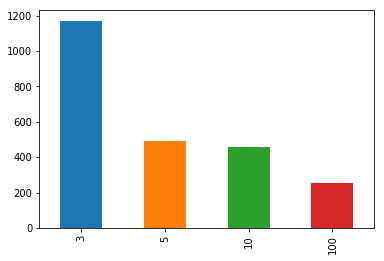



 reviews_Electronics_5.json.gz
Overall Negative Comments associated with reviews are  --  6.43652453131327
Negative values Distributions supported by helpful flag 
 3      34.106231
5       6.884341
10      6.936767
100     7.290871
Name: helpful, dtype: float64


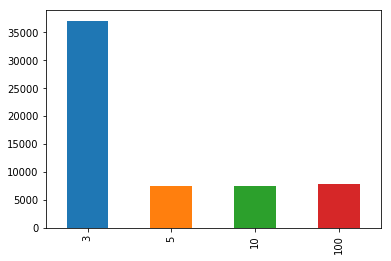



 reviews_Grocery_and_Gourmet_Food_5.json.gz
Overall Negative Comments associated with reviews are  --  3.8207254023034096
Negative values Distributions supported by helpful flag 
 3      40.716387
5       8.080983
10      6.091019
100     5.623810
Name: helpful, dtype: float64


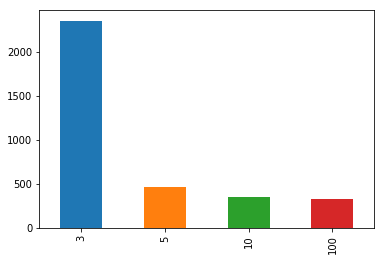



 reviews_Home_and_Kitchen_5.json.gz
Overall Negative Comments associated with reviews are  --  4.913337756171128
Negative values Distributions supported by helpful flag 
 3      36.918026
5       8.311813
10      8.883642
100    10.894267
Name: helpful, dtype: float64


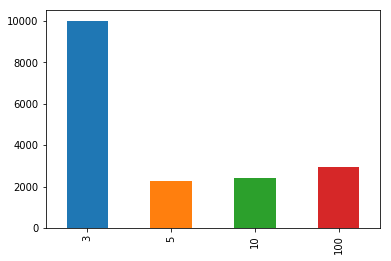



 reviews_Kindle_Store_5.json.gz
Overall Negative Comments associated with reviews are  --  2.3425152576939787
Negative values Distributions supported by helpful flag 
 3      37.692241
5       7.181336
10      6.881571
100     5.513077
Name: helpful, dtype: float64


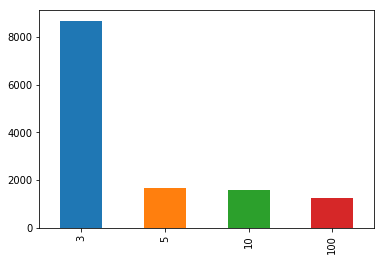



 reviews_Movies_and_TV_5.json.gz
Overall Negative Comments associated with reviews are  --  6.139438820924247
Negative values Distributions supported by helpful flag 
 3      37.228336
5      13.456280
10     15.313906
100    12.777900
Name: helpful, dtype: float64


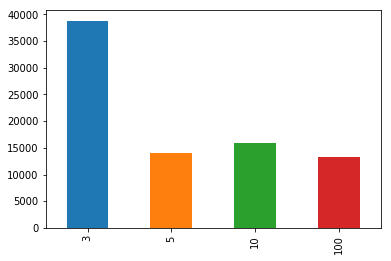



 reviews_Musical_Instruments_5.json.gz
Overall Negative Comments associated with reviews are  --  2.1148036253776437
Negative values Distributions supported by helpful flag 
 3      35.023041
5       6.451613
10      4.608295
100     3.686636
Name: helpful, dtype: float64


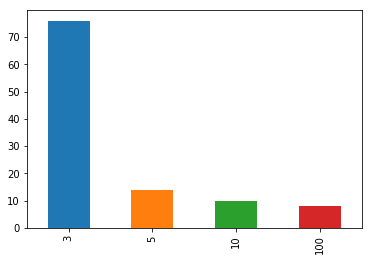



 reviews_Office_Products_5.json.gz
Overall Negative Comments associated with reviews are  --  2.1217469675917235
Negative values Distributions supported by helpful flag 
 3      37.964602
5       7.345133
10      7.168142
100     8.672566
Name: helpful, dtype: float64


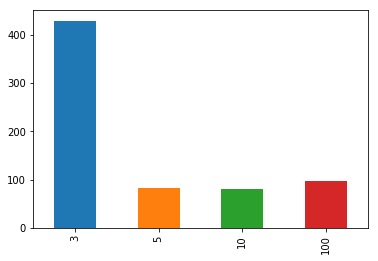



 reviews_Patio_Lawn_and_Garden_5.json.gz
Overall Negative Comments associated with reviews are  --  3.9104882459312837
Negative values Distributions supported by helpful flag 
 3      39.884393
5       7.129094
10      5.587669
100     9.826590
Name: helpful, dtype: float64


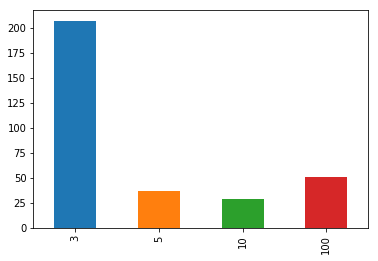



 reviews_Pet_Supplies_5.json.gz
Overall Negative Comments associated with reviews are  --  5.542461795788033
Negative values Distributions supported by helpful flag 
 3      35.791038
5       5.761317
10      4.766804
100     4.378144
Name: helpful, dtype: float64


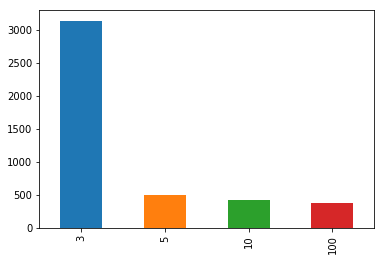



 reviews_Sports_and_Outdoors_5.json.gz
Overall Negative Comments associated with reviews are  --  3.052268194656759
Negative values Distributions supported by helpful flag 
 3      35.986733
5       6.522941
10      6.434494
100     5.096739
Name: helpful, dtype: float64


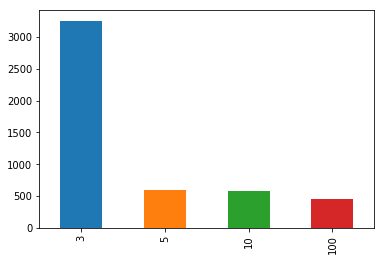



 reviews_Tools_and_Home_Improvement_5.json.gz
Overall Negative Comments associated with reviews are  --  3.8244742556292572
Negative values Distributions supported by helpful flag 
 3      35.737896
5       9.060859
10      9.585845
100    11.121913
Name: helpful, dtype: float64


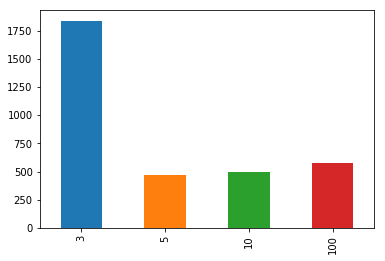



 reviews_Video_Games_5.json.gz
Overall Negative Comments associated with reviews are  --  6.408231944084908
Negative values Distributions supported by helpful flag 
 3      34.215310
5      10.927085
10     14.051033
100    15.128257
Name: helpful, dtype: float64


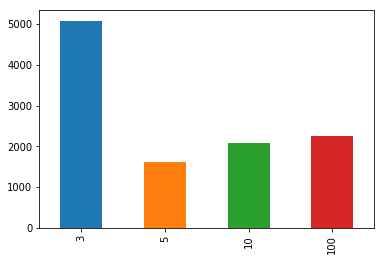

In [74]:
for file in os.listdir(folder):
    df = getDF(os.path.join(folder,file))
    df1 = df.loc[df.overall==1]
    print('\n\n',file)
    print('Overall Negative Comments associated with reviews are  -- ',df.overall.eq(1).sum()/df.shape[0]*100)
    FlagDist = pd.cut(df1.helpful.str[0],[0,3,5,10,100],labels=[3,5,10,100]).value_counts().sort_index()
    print('Negative values Distributions supported by helpful flag \n',FlagDist/df1.shape[0]*100)
    FlagDist.plot(kind='bar')
    plt.show()


reviews_Grocery_and_Gourmet_Food_5.json.gz
Overall Negative Comments associated with reviews are  --  3.8207254023034096
Negative values Distributions supported by helpful flag 
 3      40.716387
5       8.080983
10      6.091019
100     5.623810
Name: helpful, dtype: float64


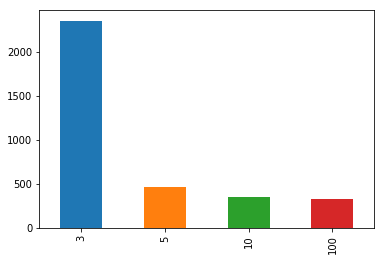

In [46]:
file = os.listdir(folder)[9]
df = getDF(os.path.join(folder,file))
df1 = df.loc[df.overall==1]
print(file)
print('Overall Negative Comments associated with reviews are  -- ',df.overall.eq(1).sum()/df.shape[0]*100)
FlagDist = pd.cut(df1.helpful.str[0],[0,3,5,10,100],labels=[3,5,10,100]).value_counts().sort_index()
print('Negative values Distributions supported by helpful flag \n',FlagDist/df1.shape[0]*100)
FlagDist.plot(kind='bar')

In [64]:
os.listdir(folder)

['reviews_Amazon_Instant_Video_5.json.gz',
 'reviews_Apps_for_Android_5.json.gz',
 'reviews_Automotive_5.json.gz',
 'reviews_Baby_5.json.gz',
 'reviews_Beauty_5.json.gz',
 'reviews_Cell_Phones_and_Accessories_5.json.gz',
 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz',
 'reviews_Digital_Music_5.json.gz',
 'reviews_Electronics_5.json.gz',
 'reviews_Grocery_and_Gourmet_Food_5.json.gz',
 'reviews_Home_and_Kitchen_5.json.gz',
 'reviews_Kindle_Store_5.json.gz',
 'reviews_Movies_and_TV_5.json.gz',
 'reviews_Musical_Instruments_5.json.gz',
 'reviews_Office_Products_5.json.gz',
 'reviews_Patio_Lawn_and_Garden_5.json.gz',
 'reviews_Pet_Supplies_5.json.gz',
 'reviews_Sports_and_Outdoors_5.json.gz',
 'reviews_Tools_and_Home_Improvement_5.json.gz',
 'reviews_Video_Games_5.json.gz']

In [65]:
os.listdir(folder).index('reviews_Musical_Instruments_5.json.gz')

13

In [67]:
a = df2[df2.helpful.str[0].gt(100)][['reviewText','helpful']]['reviewText']
ProcessedText = preprocess(' '.join(a))
ProcessedWords = nltk.pos_tag(nltk.tokenize.word_tokenize(ProcessedText))
pd.Series([word[0] for word in ProcessedWords if word[1] in ['NN', 'VBN', 'NNS']]).value_counts()

Series([], dtype: int64)

In [22]:
import webbrowser
product = 'bnatural juice'
a = 'https://www.bigbasket.com/ps/?q=' + '%20'.join(product.split(' '))

webbrowser.open_new_tab(a)

True

True

In [7]:
import requests

from bs4 import BeautifulSoup 
r  = requests.get("http://www.game-debate.com/games/index.php?g_id=21580&game=000%20Plus").content

soup = BeautifulSoup(r,"lxml")
cont = soup.select_one("div.systemRequirementsRamContent")
ram = cont.select_one("span")
print(ram["title"], ram.text)
for span in soup.select("div.systemRequirementsSmallerBox.sysReqGameSmallBox span"):
        print(span["title"],span.text)

AttributeError: 'NoneType' object has no attribute 'select_one'